# Train a Pointcloud classifier in 5 lines of code

> **Skill level:** _Beginner_

Kaolin makes 3D deep learning easy, by providing all the _hard_/_tricky_ parts of coding up a 3D DL application. To get a feel for how easy training classifiers on 3D data has become, here's a quick demo.

In this tutorial, we will train a _pointcloud_ classifier, in about five lines of code!

For those who are new to pointclouds, here's how they look like.

<p align="center">
    <img src="../../assets/airplane_points.png">
</p>

We will use the `ModelNet10` dataset for the remainder of this tutorial. The remainder of this tutorial will be broken down into the following components.

- [Downloading ModelNet10](#downloading-modelnet10)
- [DataLoading](#dataloading)
- [Training the pointcloud classifier](#training-the-pointcloud-classifier)
- [Bells and whistles](#bells-and-whistles)

## Downloading ModelNet10

Note that the ModelNet10 dataset is provided ONLY for the convenience of academic research. Should you choose to download it, you must adhere to the original terms and copyright notice of the dataset. For convenience, we reproduce the original copyright from the dataset creators.

```
**Copyright**

All CAD models are downloaded from the Internet and the original authors hold the copyright of the CAD models. The label of the data was obtained by us via Amazon Mechanical Turk service and it is provided freely. This dataset is provided for the convenience of academic research only.
```

The ModelNet10 (10-class subset) dataset is available on the [Princeton ModelNet page](https://modelnet.cs.princeton.edu/). On this page, navigate to the ModelNet10 download link to obtain the dataset. We assume that it is unzipped and extracted to a location `MODELNET_DIRECTORY`.

## Warm-up

Before all the fun-stuff begins, let us import all necessary functions from `kaolin` and `torch`. A bit more on what the following modules do will become clear as we progress.

In [4]:
import torch
from torch.utils.data import DataLoader
import kaolin as kal
from kaolin import ClassificationEngine
from kaolin.datasets import ModelNet
from kaolin.models.PointNet import PointNetClassifier as PointNet
import kaolin.transforms as tfs

## Dataloading

Kaolin provides convenience functions to load popular 3D datasets (of course, ModelNet10). Assuming you have [installed Kaolin](../../README.md#installation-and-usage), fire up your favourite python interpreter, and execute the following commands.

To start, we will define a few important parameters:

In [5]:
modelnet_path = 'data/ModelNet10/ModelNet10/'
categories = ['chair', 'sofa']
sample_points = 1024
device = 'cuda'

The `model_path` variable will hold the path to the ModelNet10 dataset. We will use the `categories` variable to specify which classes we want to learn to classify. `sample_points` is the number of points we will sample from the mesh when transforming it to a pointcloud. Finally, we will use `device = 'cuda'` to tell pytorch to run everything on the GPU.

In [6]:
transform = tfs.Compose([
    tfs.TriangleMeshToPointCloud(num_samples=sample_points),
    tfs.NormalizePointCloud()
])

This command defines a `transform` that first converts a mesh representation to a pointcloud and then _normalizes_ it to be centered at the origin, and have a standard deviation of 1. Much like images, 3D data such as pointclouds need to be normalized for better classification performance.

In [8]:
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform, device=device),
                          batch_size=12, shuffle=True)

Phew, that was slightly long! But here's what it does. It creates a `DataLoader` object for the `ModelNet10` dataset. In particular, we are interested in loading only the `chair` and `sofa` categories. The `split='train'` argument indicates that we're loading the 'train' split. The `rep='pointcloud'` loads up meshes and converts them into pointclouds. The `transform=norm` applies a normalizing transform to each pointcloud. The other parameters are fairly easy to decipher.

Similarly, the test dataset can be loaded up as follows.

In [9]:
val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform, device=device),
                        batch_size=12)

## Training the pointcloud classifier

Now that all of the data is ready, we can train our classifier using the `ClassificationEngine` class provided by Kaolin. The following line of code will train and validate a _PointNet_ classifier, which is probably the simplest of pointcloud neural architectures.

In [15]:
engine = ClassificationEngine(PointNet(num_classes=len(categories)), train_loader, val_loader, device='cuda:0')
engine.fit()

Epoch: 0, Train loss: 0.69972825050354, Train accuracy: 0.5833333730697632
Epoch: 0, Train loss: 0.6432180106639862, Train accuracy: 0.6666666865348816
Epoch: 0, Train loss: 0.5619030992190043, Train accuracy: 0.7222222487131754
Epoch: 0, Train loss: 0.5550701916217804, Train accuracy: 0.7291666865348816
Epoch: 0, Train loss: 0.6064144730567932, Train accuracy: 0.7333333492279053
Epoch: 0, Train loss: 0.6022451321283976, Train accuracy: 0.750000019868215
Epoch: 0, Train loss: 0.6037102852548871, Train accuracy: 0.738095257963453
Epoch: 0, Train loss: 0.5688892528414726, Train accuracy: 0.7500000223517418
Epoch: 0, Train loss: 0.5244567940632502, Train accuracy: 0.7777777976459928
Epoch: 0, Train loss: 0.5046747669577598, Train accuracy: 0.7916666865348816
Epoch: 0, Train loss: 0.47613064673813904, Train accuracy: 0.803030322898518
Epoch: 0, Train loss: 0.44476822825769585, Train accuracy: 0.8194444626569748
Epoch: 0, Train loss: 0.4479019922705797, Train accuracy: 0.8269230952629676
Ep

Epoch: 0, Train loss: 0.1857070577391815, Train accuracy: 0.9299065554253408
Epoch: 0, Train loss: 0.18786779348738492, Train accuracy: 0.9282407539862173
Epoch: 0, Train loss: 0.18651164247047738, Train accuracy: 0.9288990956927659
Epoch: 0, Train loss: 0.18578332919119434, Train accuracy: 0.9295454675501044
Epoch: 0, Train loss: 0.18613440911747045, Train accuracy: 0.9294294424959131
Epoch: 0, Train loss: 0.18529777400960615, Train accuracy: 0.9300595367593425
Epoch: 0, Train loss: 0.1838027629589217, Train accuracy: 0.9306784789119147
Epoch: 0, Train loss: 0.18330261363696895, Train accuracy: 0.930555568452467
Epoch: 0, Train loss: 0.18383251717719046, Train accuracy: 0.9304347955662271
Epoch: 0, Train loss: 0.18284413004133465, Train accuracy: 0.9310344956044493
Epoch: 0, Train loss: 0.18244674703918207, Train accuracy: 0.9316239443599669
Epoch: 0, Train loss: 0.18193945469397863, Train accuracy: 0.9314971879377203
Epoch: 0, Train loss: 0.18108665890709943, Train accuracy: 0.932072

Epoch: 1, Train loss: 0.08496349474245851, Train accuracy: 0.9696969769217751
Epoch: 1, Train loss: 0.0842701128836888, Train accuracy: 0.9701492608483158
Epoch: 1, Train loss: 0.08418167908402051, Train accuracy: 0.9705882423064288
Epoch: 1, Train loss: 0.09588868160178696, Train accuracy: 0.9685990413029989
Epoch: 1, Train loss: 0.09474109268880317, Train accuracy: 0.9690476264272417
Epoch: 1, Train loss: 0.09365996003518222, Train accuracy: 0.9694835753508018
Epoch: 1, Train loss: 0.09355645884190583, Train accuracy: 0.9687500074505806
Epoch: 1, Train loss: 0.09344890038801791, Train accuracy: 0.9691780895402987
Epoch: 1, Train loss: 0.09448758430930006, Train accuracy: 0.9684684759861714
Epoch: 1, Train loss: 0.0945073991889755, Train accuracy: 0.9677777854601542
Epoch: 1, Train loss: 0.09555377378618639, Train accuracy: 0.9671052710006112
Epoch: 1, Train loss: 0.09570332276695348, Train accuracy: 0.9664502244491082
Epoch: 1, Train loss: 0.09507184469690308, Train accuracy: 0.96688

Epoch: 2, Train loss: 0.1072647306881845, Train accuracy: 0.9633333420753479
Epoch: 2, Train loss: 0.10453194915316999, Train accuracy: 0.9647435981493729
Epoch: 2, Train loss: 0.10231112680156473, Train accuracy: 0.9660493908105073
Epoch: 2, Train loss: 0.10252028642155762, Train accuracy: 0.9642857228006635
Epoch: 2, Train loss: 0.10372157489624002, Train accuracy: 0.9626436870673607
Epoch: 2, Train loss: 0.10161657847153643, Train accuracy: 0.9638888974984486
Epoch: 2, Train loss: 0.1084905864460574, Train accuracy: 0.9623656003705917
Epoch: 2, Train loss: 0.10540575550112408, Train accuracy: 0.9635416753590107
Epoch: 2, Train loss: 0.10252626269886439, Train accuracy: 0.9646464730754043
Epoch: 2, Train loss: 0.1021584165693425, Train accuracy: 0.963235302883036
Epoch: 2, Train loss: 0.10130954370168703, Train accuracy: 0.9642857228006635
Epoch: 2, Train loss: 0.1476046333943183, Train accuracy: 0.9583333416117562
Epoch: 2, Train loss: 0.15606677035071156, Train accuracy: 0.95495496

Epoch: 2, Train loss: 0.11693822609203804, Train accuracy: 0.9643765979140769
Epoch: 2, Val loss: 0.047181110829114914, Val accuracy: 1.0
Epoch: 2, Val loss: 0.0667406190186739, Val accuracy: 1.0
Epoch: 2, Val loss: 0.07271441941459973, Val accuracy: 1.0
Epoch: 2, Val loss: 0.08715080935508013, Val accuracy: 1.0
Epoch: 2, Val loss: 0.08845150992274284, Val accuracy: 0.9833333373069764
Epoch: 2, Val loss: 0.08743234040836494, Val accuracy: 0.9861111144224802
Epoch: 2, Val loss: 0.07733114888625485, Val accuracy: 0.9880952409335545
Epoch: 2, Val loss: 0.07503068051300943, Val accuracy: 0.9895833358168602
Epoch: 2, Val loss: 0.07903683247665565, Val accuracy: 0.9907407429483202
Epoch: 2, Val loss: 0.08453381564468146, Val accuracy: 0.9833333373069764
Epoch: 2, Val loss: 0.13220402784645557, Val accuracy: 0.9393939430063422
Epoch: 2, Val loss: 0.12767502649997672, Val accuracy: 0.9444444477558136
Epoch: 2, Val loss: 0.13535048397114643, Val accuracy: 0.942307696892665
Epoch: 2, Val loss: 0

Epoch: 3, Train loss: 0.12603483184824113, Train accuracy: 0.9551282151714786
Epoch: 3, Train loss: 0.12521561514080057, Train accuracy: 0.955615951963093
Epoch: 3, Train loss: 0.1264090461466181, Train accuracy: 0.9551971426574133
Epoch: 3, Train loss: 0.12529044786091656, Train accuracy: 0.9556737687993557
Epoch: 3, Train loss: 0.12450033004248613, Train accuracy: 0.9561403607067309
Epoch: 3, Train loss: 0.1234568016710303, Train accuracy: 0.9565972319493691
Epoch: 3, Train loss: 0.12239759409147286, Train accuracy: 0.9570446831663859
Epoch: 3, Train loss: 0.12134383635462395, Train accuracy: 0.9574830027259126
Epoch: 3, Train loss: 0.12045913405547087, Train accuracy: 0.9579124673448428
Epoch: 3, Train loss: 0.12065701810177415, Train accuracy: 0.9575000095367432
Epoch: 3, Train loss: 0.12259274748347626, Train accuracy: 0.957095719209992
Epoch: 3, Train loss: 0.12482591438581984, Train accuracy: 0.9566993561445498
Epoch: 3, Train loss: 0.12373720276287024, Train accuracy: 0.9571197

Epoch: 4, Train loss: 0.0908532893803533, Train accuracy: 0.97327044549978
Epoch: 4, Train loss: 0.09140664964690115, Train accuracy: 0.9722222277411708
Epoch: 4, Train loss: 0.0902196750510484, Train accuracy: 0.9727272781458768
Epoch: 4, Train loss: 0.09085986381978728, Train accuracy: 0.973214291036129
Epoch: 4, Train loss: 0.0905021549766197, Train accuracy: 0.9736842157547934
Epoch: 4, Train loss: 0.08923536321902968, Train accuracy: 0.9741379361728142
Epoch: 4, Train loss: 0.08915049091407681, Train accuracy: 0.9731638471959001
Epoch: 4, Train loss: 0.08803790684711808, Train accuracy: 0.9736111164093018
Epoch: 4, Train loss: 0.08749665736342918, Train accuracy: 0.9740437210583296
Epoch: 4, Train loss: 0.08662757783332059, Train accuracy: 0.9744623707186791
Epoch: 4, Train loss: 0.08569832439977854, Train accuracy: 0.9748677299136207
Epoch: 4, Train loss: 0.08481055112133618, Train accuracy: 0.9752604216337204
Epoch: 4, Train loss: 0.08394514644303575, Train accuracy: 0.975641030

Epoch: 5, Train loss: 0.03690687807587286, Train accuracy: 0.9888888915379842
Epoch: 5, Train loss: 0.03513770356948953, Train accuracy: 0.9895833358168602
Epoch: 5, Train loss: 0.03400718808338484, Train accuracy: 0.9901960807688096
Epoch: 5, Train loss: 0.0331104054607244, Train accuracy: 0.9907407429483202
Epoch: 5, Train loss: 0.03443096013200518, Train accuracy: 0.9912280722668296
Epoch: 5, Train loss: 0.04230370729928836, Train accuracy: 0.9875000029802322
Epoch: 5, Train loss: 0.041061263830800145, Train accuracy: 0.9880952409335545
Epoch: 5, Train loss: 0.03938479282342913, Train accuracy: 0.9886363663456657
Epoch: 5, Train loss: 0.044272822216558066, Train accuracy: 0.989130437374115
Epoch: 5, Train loss: 0.042758491210406646, Train accuracy: 0.9895833358168602
Epoch: 5, Train loss: 0.041837494680657984, Train accuracy: 0.9900000023841858
Epoch: 5, Train loss: 0.040657487348653376, Train accuracy: 0.9903846176771017
Epoch: 5, Train loss: 0.039305455801594585, Train accuracy: 0

Epoch: 5, Train loss: 0.0441736172826495, Train accuracy: 0.9861111144224802
Epoch: 5, Train loss: 0.04397017706747452, Train accuracy: 0.9862258986008069
Epoch: 5, Train loss: 0.04362914299012208, Train accuracy: 0.986338801071292
Epoch: 5, Train loss: 0.04497425527713163, Train accuracy: 0.9850948545021739
Epoch: 5, Train loss: 0.044630349232559846, Train accuracy: 0.9852150572884467
Epoch: 5, Train loss: 0.04531008703447879, Train accuracy: 0.9840000038146972
Epoch: 5, Train loss: 0.04500141446959109, Train accuracy: 0.9841269879114061
Epoch: 5, Train loss: 0.044666432947888385, Train accuracy: 0.9842519722585603
Epoch: 5, Train loss: 0.0443759603149374, Train accuracy: 0.9843750037252903
Epoch: 5, Train loss: 0.04405878479195426, Train accuracy: 0.9844961277274198
Epoch: 5, Train loss: 0.04372713916146984, Train accuracy: 0.9846153882833627
Epoch: 5, Train loss: 0.043541618523308796, Train accuracy: 0.9847328280674592
Epoch: 5, Val loss: 0.010908246040344238, Val accuracy: 1.0
Epoc

Epoch: 6, Train loss: 0.04961978249757746, Train accuracy: 0.9825102922357158
Epoch: 6, Train loss: 0.04905401401664698, Train accuracy: 0.9827235813547925
Epoch: 6, Train loss: 0.0491450252095574, Train accuracy: 0.9829317309770239
Epoch: 6, Train loss: 0.04857425370747002, Train accuracy: 0.9831349246558689
Epoch: 6, Train loss: 0.051626326550510436, Train accuracy: 0.9813725534607383
Epoch: 6, Train loss: 0.053477023891985505, Train accuracy: 0.9806201596592747
Epoch: 6, Train loss: 0.05290522586002989, Train accuracy: 0.9808429164448004
Epoch: 6, Train loss: 0.055624809763023884, Train accuracy: 0.9791666716337204
Epoch: 6, Train loss: 0.055586865581205805, Train accuracy: 0.9794007539749146
Epoch: 6, Train loss: 0.06407356573812042, Train accuracy: 0.9777777830759684
Epoch: 6, Train loss: 0.06348134628573822, Train accuracy: 0.9780219832619468
Epoch: 6, Train loss: 0.06285170370677445, Train accuracy: 0.97826087474823
Epoch: 6, Train loss: 0.06334603884412597, Train accuracy: 0.97

Epoch: 7, Train loss: 0.030844853629565072, Train accuracy: 0.9888888915379842
Epoch: 7, Train loss: 0.037120386611407055, Train accuracy: 0.9873188436031342
Epoch: 7, Train loss: 0.056984812950101146, Train accuracy: 0.9840425569960412
Epoch: 7, Train loss: 0.055820141276247646, Train accuracy: 0.9843750037252903
Epoch: 7, Train loss: 0.05603363545259879, Train accuracy: 0.9846938812002843
Epoch: 7, Train loss: 0.055383180023636666, Train accuracy: 0.9850000035762787
Epoch: 7, Train loss: 0.054905591475521674, Train accuracy: 0.9852941211532144
Epoch: 7, Train loss: 0.05568008509670527, Train accuracy: 0.9839743627951696
Epoch: 7, Train loss: 0.05951562114191716, Train accuracy: 0.9811320799701618
Epoch: 7, Train loss: 0.05847954403186493, Train accuracy: 0.9814814858966403
Epoch: 7, Train loss: 0.05769878935534507, Train accuracy: 0.981818186153065
Epoch: 7, Train loss: 0.05675901687728973, Train accuracy: 0.9821428614003318
Epoch: 7, Train loss: 0.05594498932712891, Train accuracy: 

Epoch: 8, Train loss: 0.024153671343810856, Train accuracy: 0.9722222288449606
Epoch: 8, Train loss: 0.018722475826507434, Train accuracy: 0.9791666716337204
Epoch: 8, Train loss: 0.03172568629961461, Train accuracy: 0.9666666746139526
Epoch: 8, Train loss: 0.027632095365940284, Train accuracy: 0.9722222288449606
Epoch: 8, Train loss: 0.03724516434262374, Train accuracy: 0.9642857228006635
Epoch: 8, Train loss: 0.04542367566318717, Train accuracy: 0.9583333432674408
Epoch: 8, Train loss: 0.04910647236586859, Train accuracy: 0.9629629717932807
Epoch: 8, Train loss: 0.04480811086250469, Train accuracy: 0.9666666746139526
Epoch: 8, Train loss: 0.04185481622434137, Train accuracy: 0.9696969769217751
Epoch: 8, Train loss: 0.03853580795112066, Train accuracy: 0.9722222288449606
Epoch: 8, Train loss: 0.03621254385843013, Train accuracy: 0.9743589804722712
Epoch: 8, Train loss: 0.03447789470166234, Train accuracy: 0.976190481867109
Epoch: 8, Train loss: 0.04116463547106832, Train accuracy: 0.9

Epoch: 8, Train loss: 0.03134424713169682, Train accuracy: 0.9899691381940136
Epoch: 8, Train loss: 0.031338870862056716, Train accuracy: 0.9900611644491143
Epoch: 8, Train loss: 0.031101229849578388, Train accuracy: 0.9901515174995769
Epoch: 8, Train loss: 0.0310104847038773, Train accuracy: 0.9902402425671483
Epoch: 8, Train loss: 0.030761758103835746, Train accuracy: 0.990327383258513
Epoch: 8, Train loss: 0.030654374004467348, Train accuracy: 0.9904129816367563
Epoch: 8, Train loss: 0.0304020025071447, Train accuracy: 0.9904970782890654
Epoch: 8, Train loss: 0.030339179149798483, Train accuracy: 0.9905797123908997
Epoch: 8, Train loss: 0.03012038370547214, Train accuracy: 0.9906609217668402
Epoch: 8, Train loss: 0.03020855085352141, Train accuracy: 0.9907407429483202
Epoch: 8, Train loss: 0.030064360544695204, Train accuracy: 0.9908192112284192
Epoch: 8, Train loss: 0.029857308817332798, Train accuracy: 0.9908963607138946
Epoch: 8, Train loss: 0.02963177236597403, Train accuracy: 0

Epoch: 9, Train loss: 0.056149068742073927, Train accuracy: 0.9835680790350471
Epoch: 9, Train loss: 0.05748303451340083, Train accuracy: 0.9826388930281004
Epoch: 9, Train loss: 0.05784499481394536, Train accuracy: 0.9817351641720289
Epoch: 9, Train loss: 0.057182913552694385, Train accuracy: 0.9819819862778122
Epoch: 9, Train loss: 0.05651474978250917, Train accuracy: 0.9822222264607747
Epoch: 9, Train loss: 0.05586576460662304, Train accuracy: 0.9824561445336593
Epoch: 9, Train loss: 0.055191540087659405, Train accuracy: 0.982683986812443
Epoch: 9, Train loss: 0.05453572605638795, Train accuracy: 0.9829059869815142
Epoch: 9, Train loss: 0.05389096451532007, Train accuracy: 0.9831223668931406
Epoch: 9, Train loss: 0.05338121428303566, Train accuracy: 0.9833333373069764
Epoch: 9, Train loss: 0.053602699596574245, Train accuracy: 0.9825102922357158
Epoch: 9, Train loss: 0.05860670573428052, Train accuracy: 0.9796748008669877
Epoch: 9, Train loss: 0.05804653863330703, Train accuracy: 0.

## Visualizing the results

We will create a new dataloder which will load the same data as our previous val_loader but with shuffling, and take a sample batch.

In [107]:
test_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform, device=device),
                        shuffle=True, batch_size=15)

test_batch, labels = next(iter(test_loader))
preds = engine.model(test_batch)
pred_labels = torch.max(preds, axis=1)[1]

Next, we setup a plot to visualize the pointcloud, groundtruth label and our prediction. Here we've also colour-coded the results - green for correct and red for incorrect. Looks like everything is green!

<IPython.core.display.Javascript object>


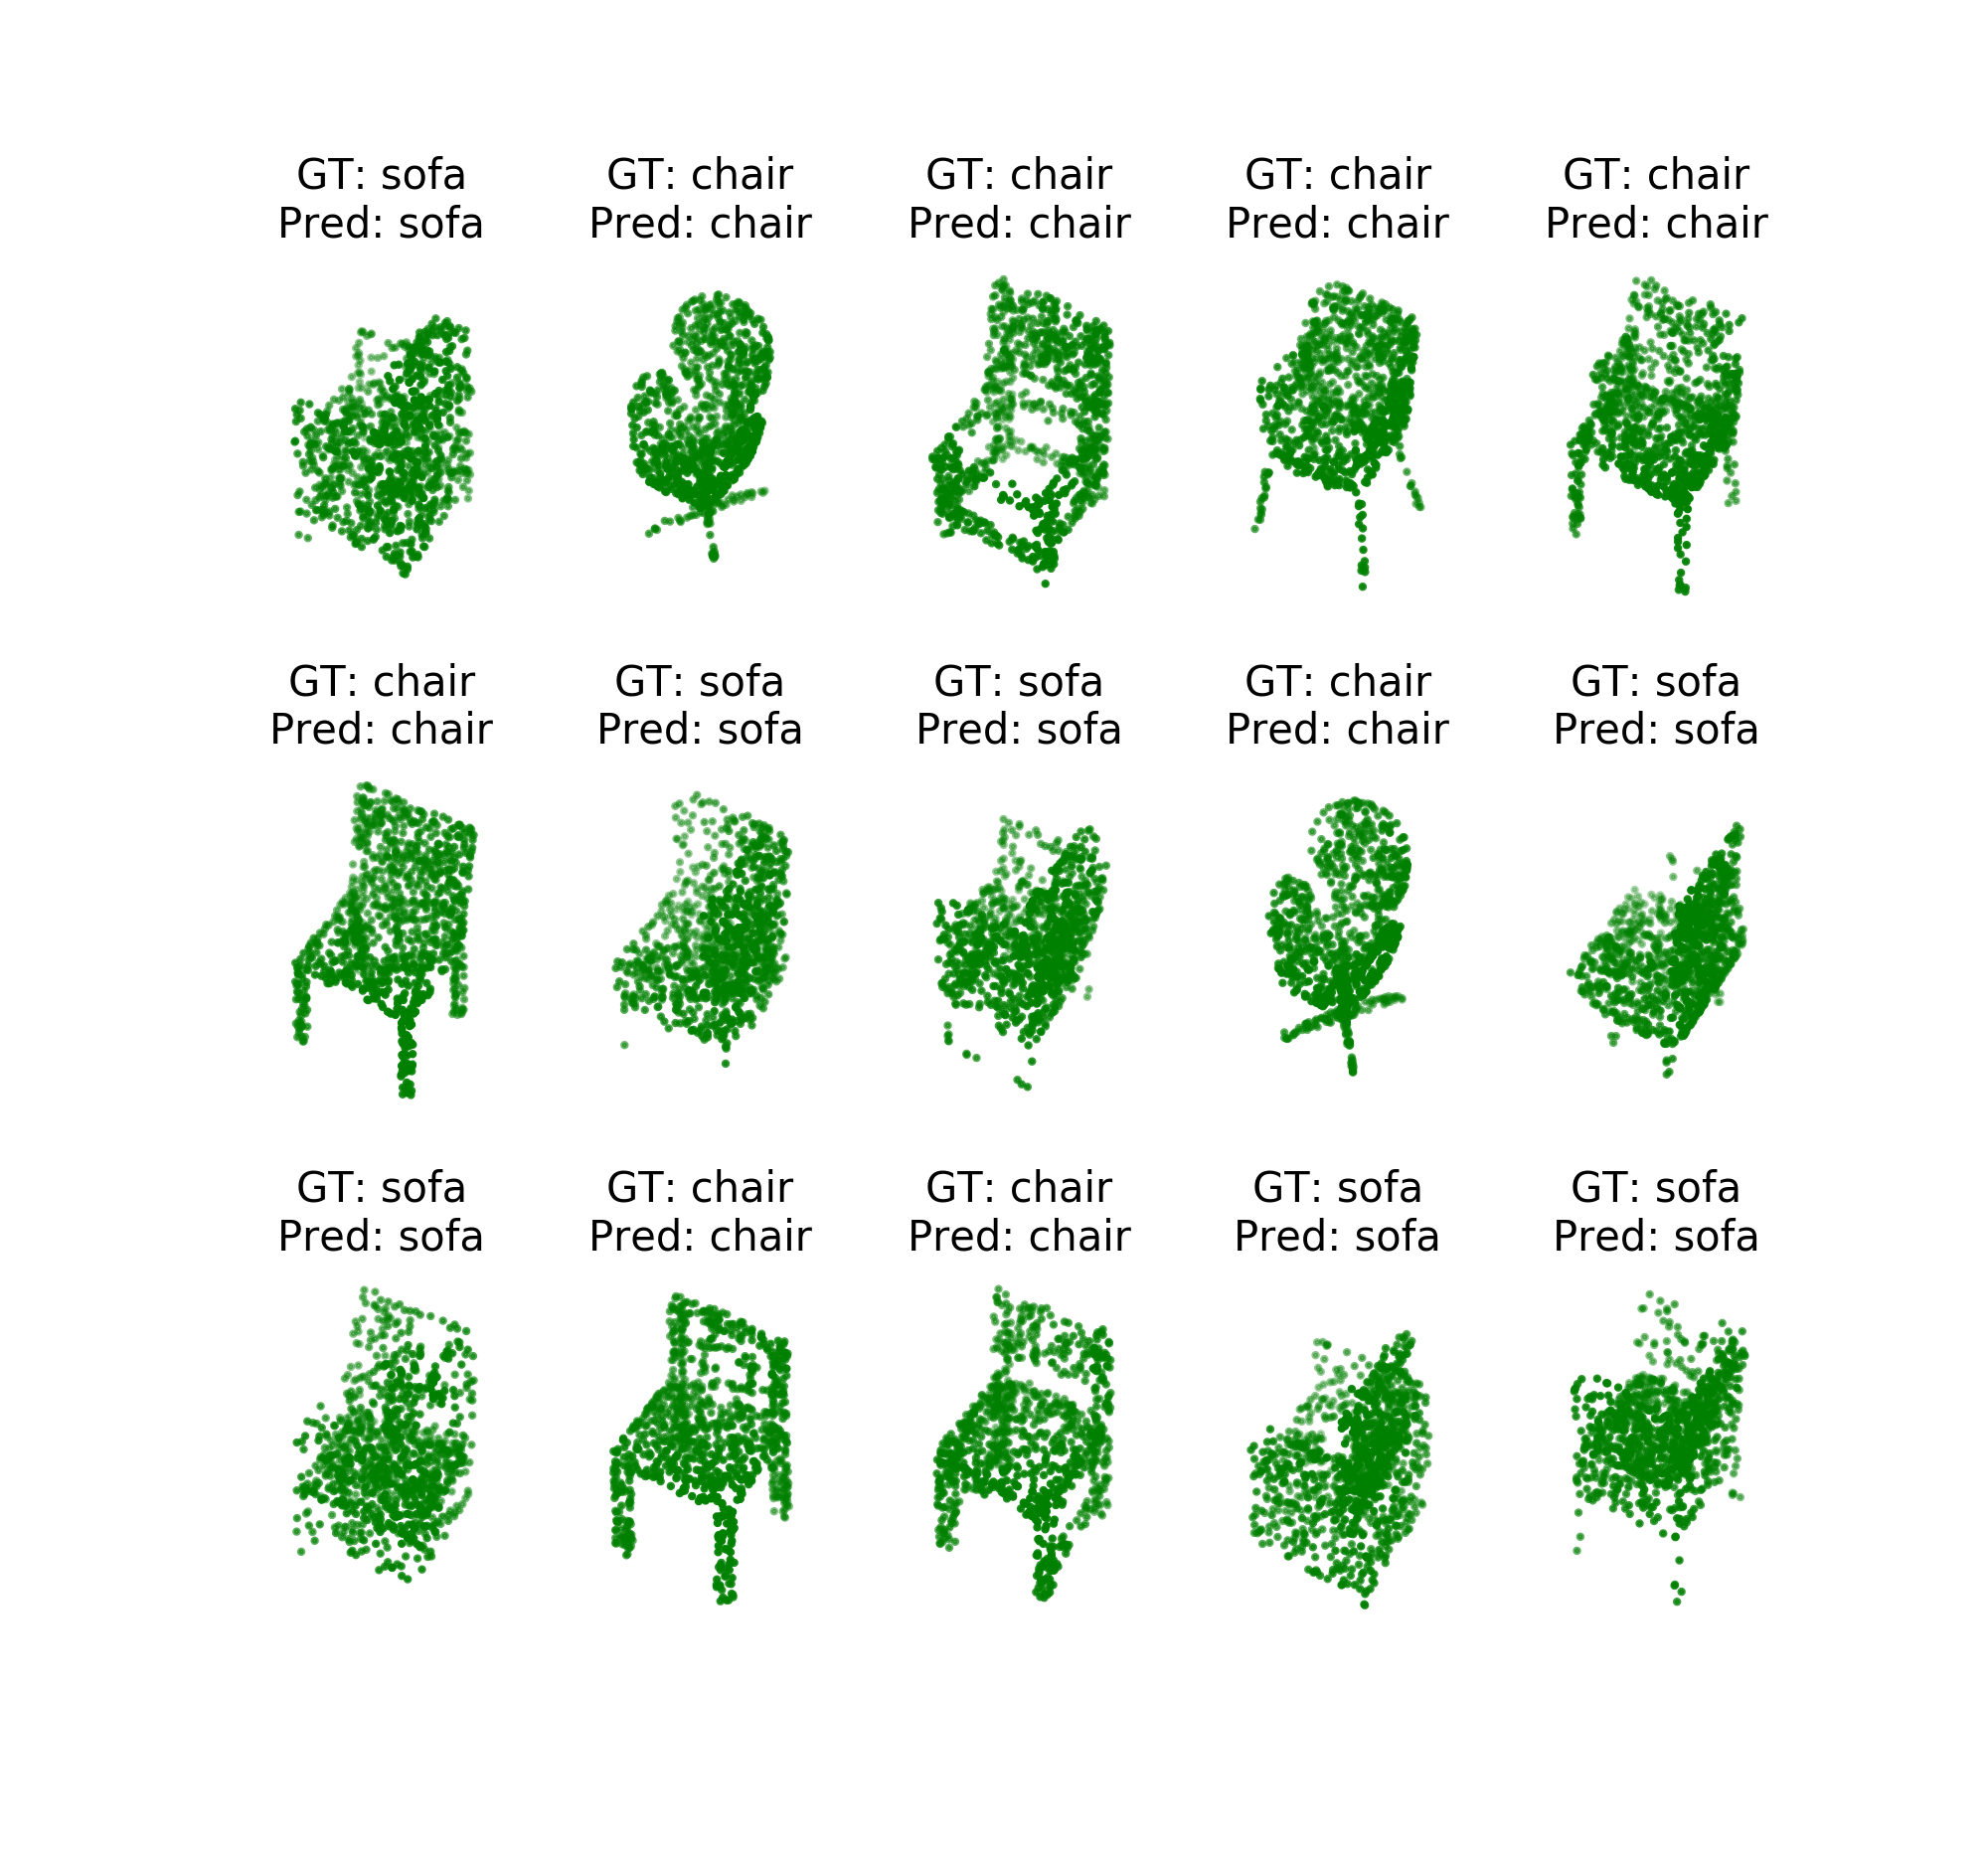

In [111]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

batch_size = len(test_batch)
fig = plt.figure(figsize=(8, batch_size / 2))

ncols = 5
nrows = max(1, batch_size // 5)
for idx, pc in enumerate(test_batch):
    label = categories[labels[idx].item()]
    pred = categories[pred_labels[idx]]
    colour = 'g' if label == pred else 'r'
    pc = pc.cpu().numpy()
    ax = fig.add_subplot(nrows, ncols, idx+1, projection='3d')
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colour, s=2)
    ax.axis('off')
    ax.set_title('GT: {0}\nPred: {1}'.format(label, pred))

That's it, you've trained your first 3D classifier on pointcloud data using Kaolin!! Read through to find out more bells-and-whistles about the `ClassificationEngine` and how you can configure it.

The code is available in `pointcloud_classification_engine.py`.

For a more explicit example without the `ClassificationEngine` class, please see the code in `pointcloud_classification.py`


## Bells and whistles

The `ClassificationEngine` can be customized to suit your needs.

You can train on other categories by simply changing the `categories` argument passed to the `ModelNet10` dataset object. For example, you can add a `bed` class by running
```
dataset = ModelNet('/path/to/ModelNet10', categories=['chair', 'sofa', 'bed'],
                   split='train', rep='pointcloud', transform=norm, device='cuda:0')
```

You can also configure the parameters of the `PointNet` to your liking. For a more detailed explanation, refer to the documentation of the `PointNetClassifier` class.

Further, you can pass several parameters that configure the learning rate, optimizer, training duration, and more. A detailed description can be accessed from the documentation for the `ClassificationEngine` class.
